# DeepFake Image detection

In [1]:
import sys
import sklearn
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np

import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

2025-05-27 19:04:36.884603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748372677.329222      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748372677.452184      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.test.is_gpu_available()

I0000 00:00:1748372698.414447      19 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748372698.415253      19 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


True

In [3]:
tf.__version__

'2.18.0'

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Data Visualisation

In [5]:
import os

def get_data():
    return pd.read_csv('../input/deepfake-faces/metadata.csv')

In [6]:
meta=get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [7]:
meta.shape

(95634, 5)

In [8]:
len(meta[meta.label=='FAKE']),len(meta[meta.label=='REAL'])

(79341, 16293)

In [9]:
real_df = meta[meta["label"] == "REAL"]
fake_df = meta[meta["label"] == "FAKE"]
sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_meta = pd.concat([real_df, fake_df])

In [10]:
from sklearn.model_selection import train_test_split

Train_set, Test_set = train_test_split(sample_meta,test_size=0.2,random_state=42,stratify=sample_meta['label'])
Train_set, Val_set  = train_test_split(Train_set,test_size=0.3,random_state=42,stratify=Train_set['label'])

In [11]:
Train_set.shape,Val_set.shape,Test_set.shape

((8960, 5), (3840, 5), (3200, 5))

In [12]:
y = dict()

y[0] = []
y[1] = []

for set_name in (np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label'])):
    y[0].append(np.sum(set_name == 'REAL'))
    y[1].append(np.sum(set_name == 'FAKE'))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='REAL',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='FAKE',
    marker=dict(color='#ff3300'),
    opacity=0.7
)

data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)

fig = go.Figure(data, layout)
iplot(fig)

The original image dataset were biased with more fake images than real since we are taking a sample of it its better to take equal proportion of real and fake images.

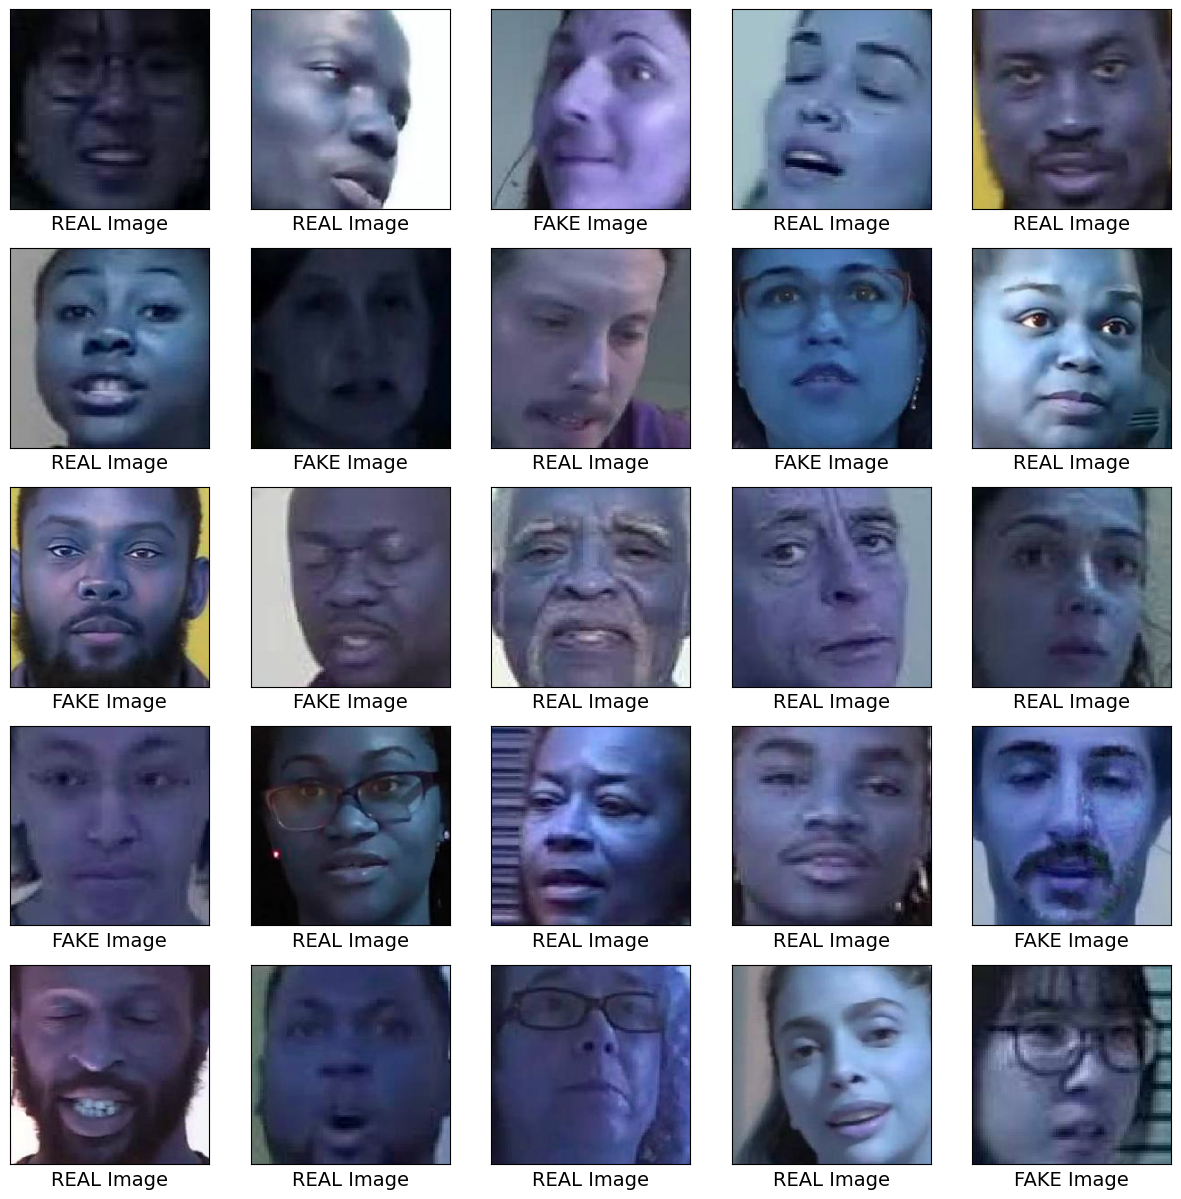

In [13]:
plt.figure(figsize=(15,15))
for cur,i in enumerate(Train_set.index[25:50]):
    plt.subplot(5,5,cur+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(cv2.imread('../input/deepfake-faces/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg'))
    
    if(Train_set.loc[i,'label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

## Modelling

Before jumping to use pretrained model lets develop some base line model to test how our pretrained model outperforms.

### Custom CNN Architecture

In [14]:
def retreive_dataset(set_name):
    images,labels=[],[]
    for (img, imclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('../input/deepfake-faces/faces_224/'+img[:-4]+'.jpg'))
        if(imclass=='FAKE'):
            labels.append(1)
        else:
            labels.append(0)
    
    return np.array(images),np.array(labels)

In [15]:
X_train,y_train=retreive_dataset(Train_set)
X_val,y_val=retreive_dataset(Val_set)
X_test,y_test=retreive_dataset(Test_set)

In [16]:
from functools import partial

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[224, 224, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

I0000 00:00:1748372834.244883      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748372834.245125      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      51,380,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,619,585 (196.91 MB)

 Trainable params: 51,619,585 (196.91 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(X_train, y_train, epochs=5,batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/5


I0000 00:00:1748372843.947777      66 service.cc:148] XLA service 0x7e2fb0013090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748372843.949226      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748372843.949256      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748372844.411672      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748372868.112588      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 ━━━━━━━━━━━━━━━━━━━━ 78s 360ms/step - accuracy: 0.4993 - loss: 771.9293 - val_accuracy: 0.5052 - val_loss: 0.6930
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 309ms/step - accuracy: 0.5083 - loss: 0.6994 - val_accuracy: 0.4995 - val_loss: 0.6932
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.4966 - loss: 0.6954 - val_accuracy: 0.4956 - val_loss: 0.6932
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 307ms/step - accuracy: 0.4957 - loss: 0.6932 - val_accuracy: 0.4953 - val_loss: 0.6934
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 43s 307ms/step - accuracy: 0.5023 - loss: 0.6931 - val_accuracy: 0.5008 - val_loss: 0.6930


In [19]:
score = model.evaluate(X_test, y_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4844 - loss: 0.6928


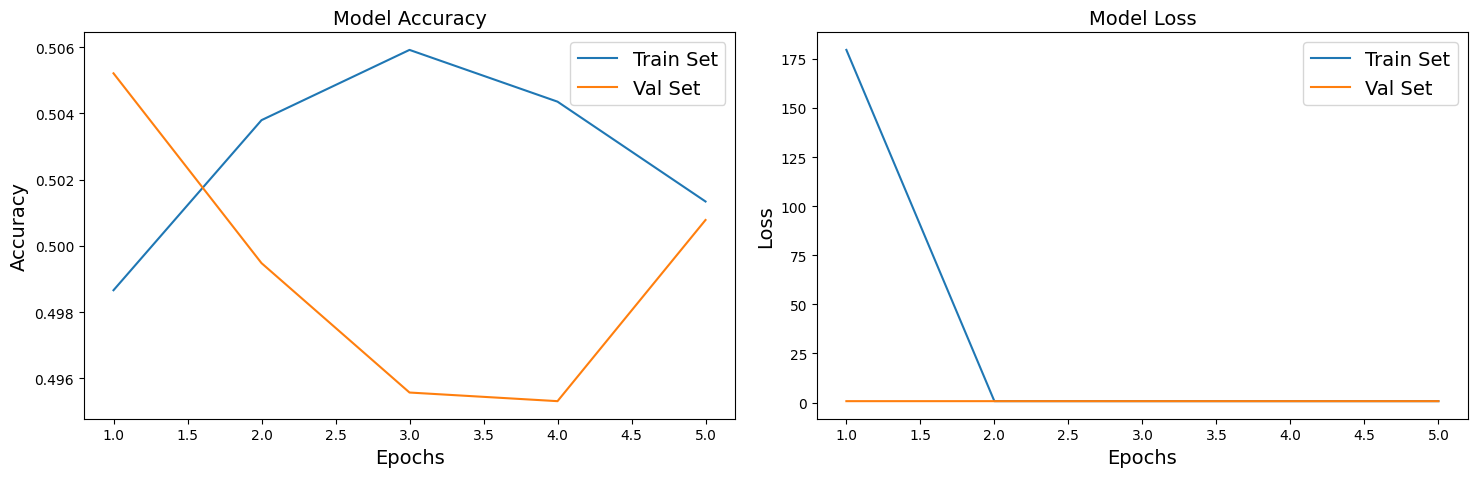

In [20]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# Pretrained Models for Transfer Learning

Here we used Xception model for fine-tuning feel free to try the performance of other pretrained models.

All three datasets contain individual images. We need to batch them, but for this we first need to ensure they all have the same size, or else batching will not work. We can use a `Resizing` layer for this. We must also call the `tf.keras.applications.xception.preprocess_input()` function to preprocess the images appropriately for the Xception model. We will also add shuffling and prefetching to the training dataset.

In [21]:
train_set_raw=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_set_raw=tf.data.Dataset.from_tensor_slices((X_val,y_val))
test_set_raw=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [22]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.applications.xception.preprocess_input
train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

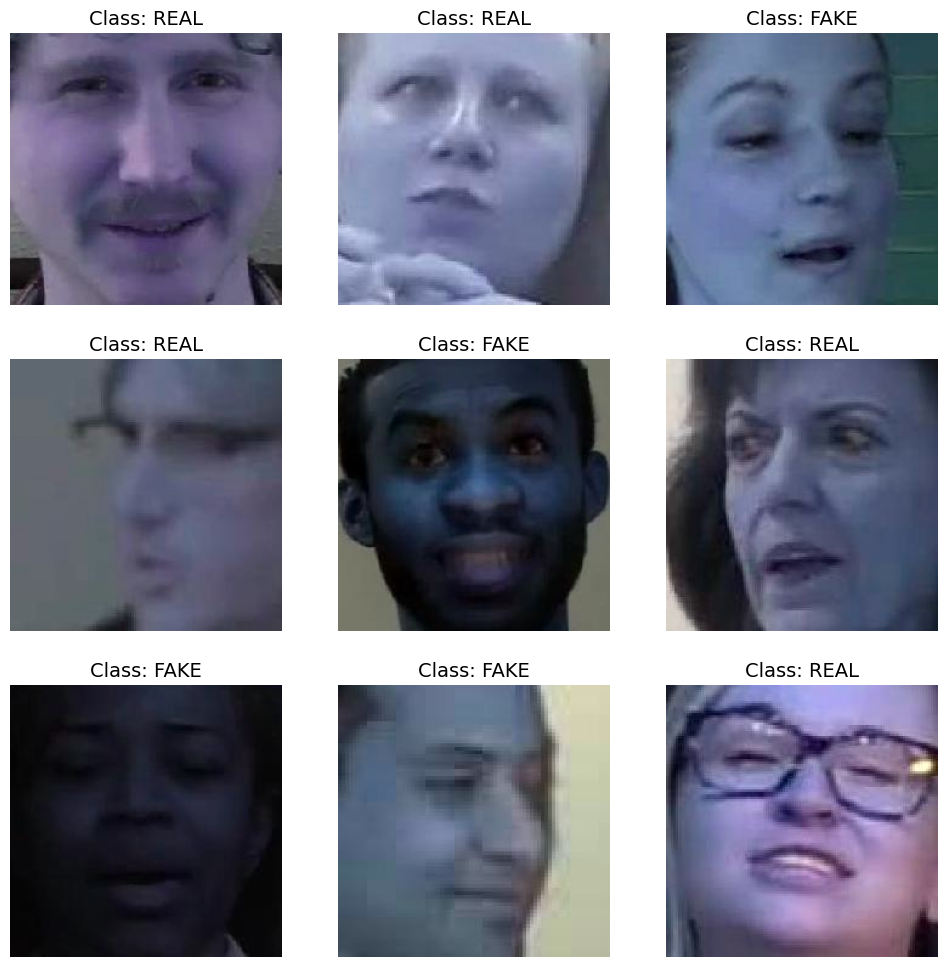

In [23]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [24]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

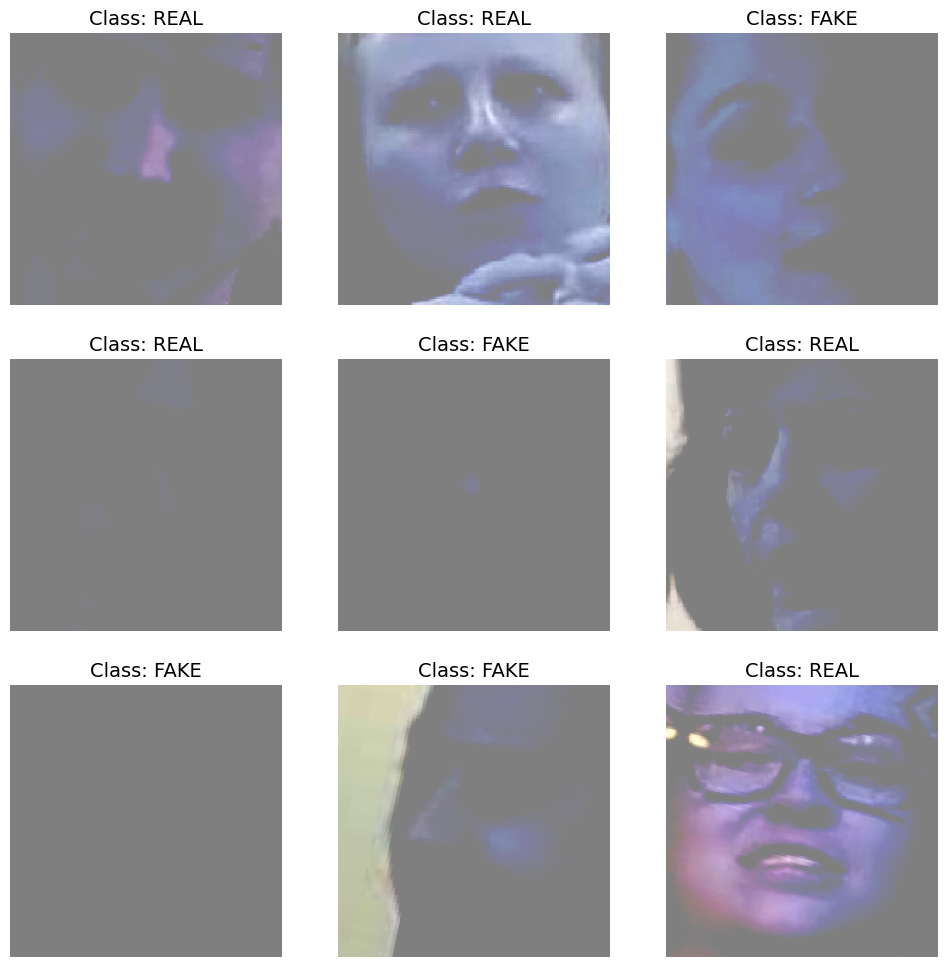

In [25]:
# extra code – displays the same first 9 images, after augmentation

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

Now let's load the pretrained model, without its top layers, and replace them with our own task

In [26]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
for layer in base_model.layers:
    layer.trainable = False

In [28]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 76s 213ms/step - accuracy: 0.5742 - loss: 0.9534 - val_accuracy: 0.5693 - val_loss: 1.4568
Epoch 2/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 55s 194ms/step - accuracy: 0.6129 - loss: 0.8845 - val_accuracy: 0.6182 - val_loss: 0.8539
Epoch 3/3
280/280 ━━━━━━━━━━━━━━━━━━━━ 55s 196ms/step - accuracy: 0.6383 - loss: 0.8666 - val_accuracy: 0.6279 - val_loss: 0.8540


In [29]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_1          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [30]:
model.evaluate(test_set)

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.6303 - loss: 0.8591


[0.8800264000892639, 0.6175000071525574]

In [31]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=20)

Epoch 1/20


E0000 00:00:1748373337.055623      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748373337.196029      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


280/280 ━━━━━━━━━━━━━━━━━━━━ 125s 364ms/step - accuracy: 0.5380 - loss: 0.7221 - val_accuracy: 0.7049 - val_loss: 0.5951
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 99s 353ms/step - accuracy: 0.7653 - loss: 0.4899 - val_accuracy: 0.7326 - val_loss: 0.5465
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 98s 350ms/step - accuracy: 0.9140 - loss: 0.2166 - val_accuracy: 0.7367 - val_loss: 0.7754
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 99s 352ms/step - accuracy: 0.9461 - loss: 0.1404 - val_accuracy: 0.7831 - val_loss: 0.6413
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 99s 351ms/step - accuracy: 0.9689 - loss: 0.0875 - val_accuracy: 0.7750 - val_loss: 0.7131
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 99s 352ms/step - accuracy: 0.9738 - loss: 0.0729 - val_accuracy: 0.7992 - val_loss: 0.7624
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 99s 352ms/step - accuracy: 0.9803 - loss: 0.0523 - val_accuracy: 0.7305 - val_loss: 1.2722
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 99s 352ms/step - accuracy: 0.9826 - loss: 0.0494 - va

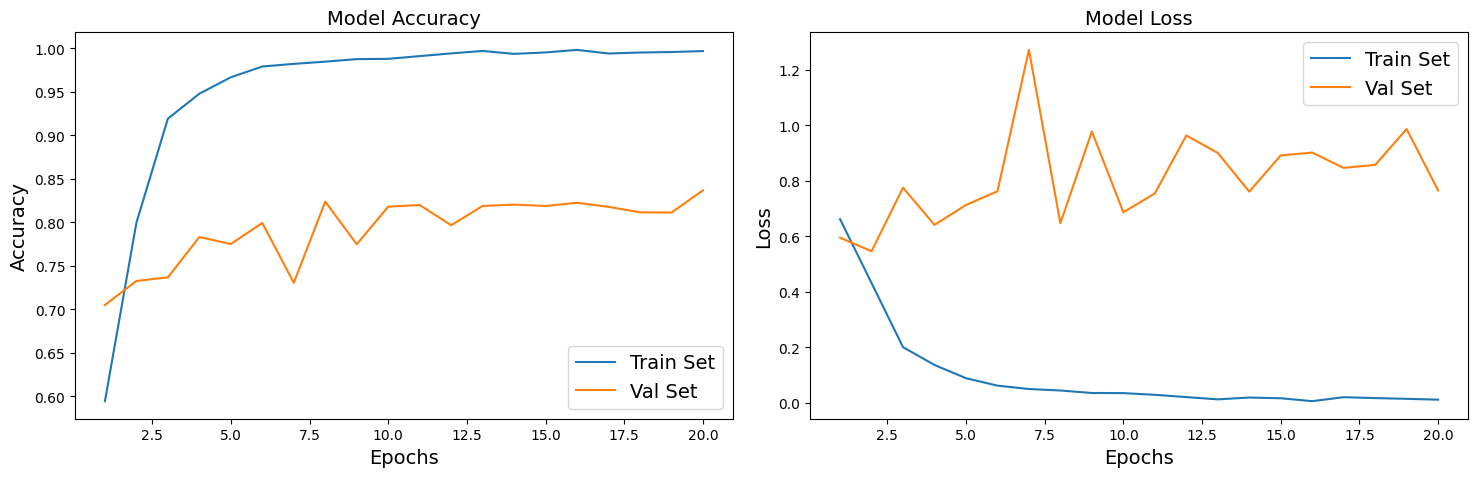

In [32]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [33]:
model.evaluate(test_set)

100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.8444 - loss: 0.6814


[0.683292031288147, 0.8418750166893005]

In [34]:
model.save('xception_deepfake_image.h5')

# Add Explainability to the model

Lets try to interpret the trained model on how it finds a image FAKE

In [35]:
!pip install lime

In [36]:
from lime import lime_image
import matplotlib.pyplot as plt

explainer = lime_image.LimeImageExplainer()

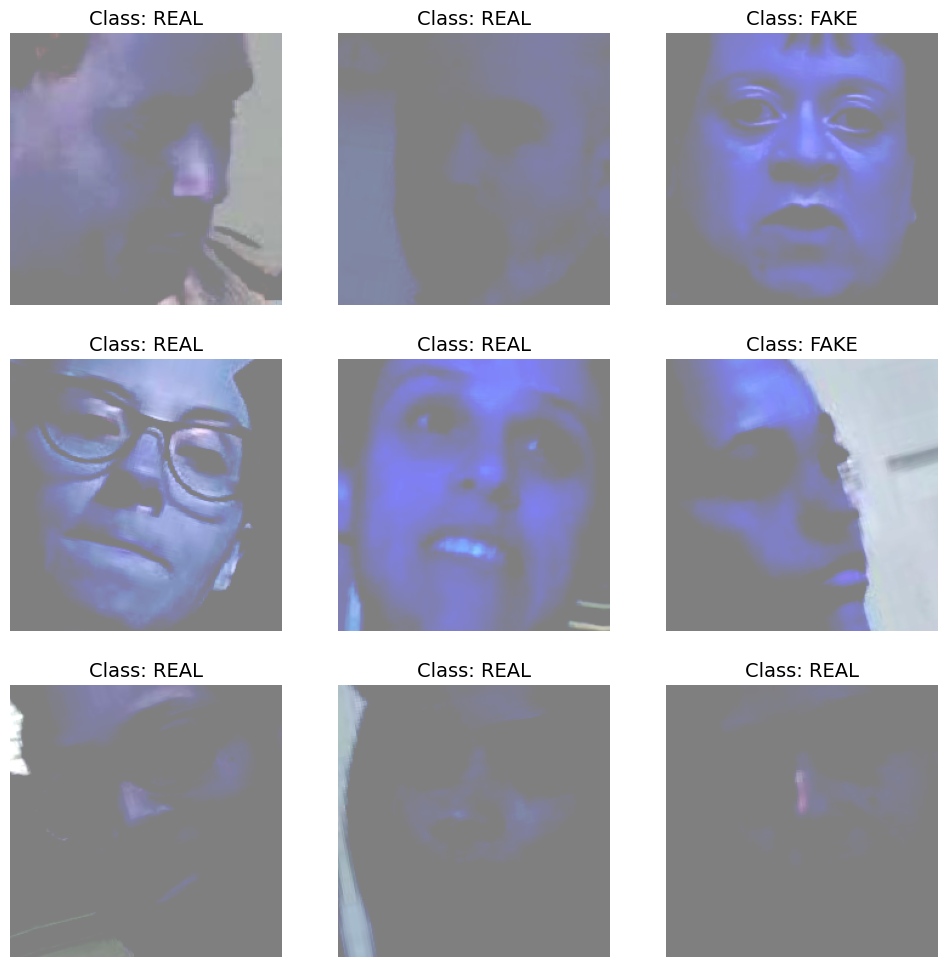

In [37]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        if(y_batch[index]==1):
            classt='FAKE'
        else:
            classt='REAL'
        plt.title(f"Class: {classt}")
        plt.axis("off")

plt.show()

In [38]:
test_data = X_test[2,:,:,:]
for X_batch, y_batch in test_set.take(1):
    test_data = data_augmentation(X_batch, training=True)

test_data = np.array(test_data[2,:,:,:])
test_data.shape

(224, 224, 3)

In [39]:
explanation = explainer.explain_instance(test_data.astype('double'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━

(-0.5, 223.5, 223.5, -0.5)

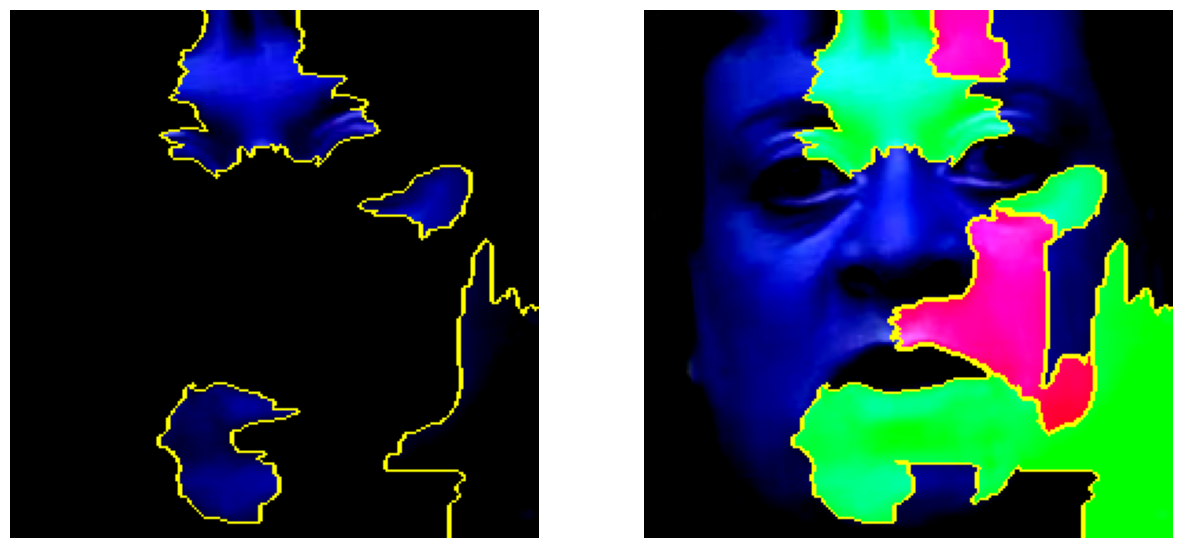

In [40]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

# Fake video detection


In [41]:
from tensorflow import keras
#from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [42]:
## Data Visualisation

Train samples: 401
Test samples: 400


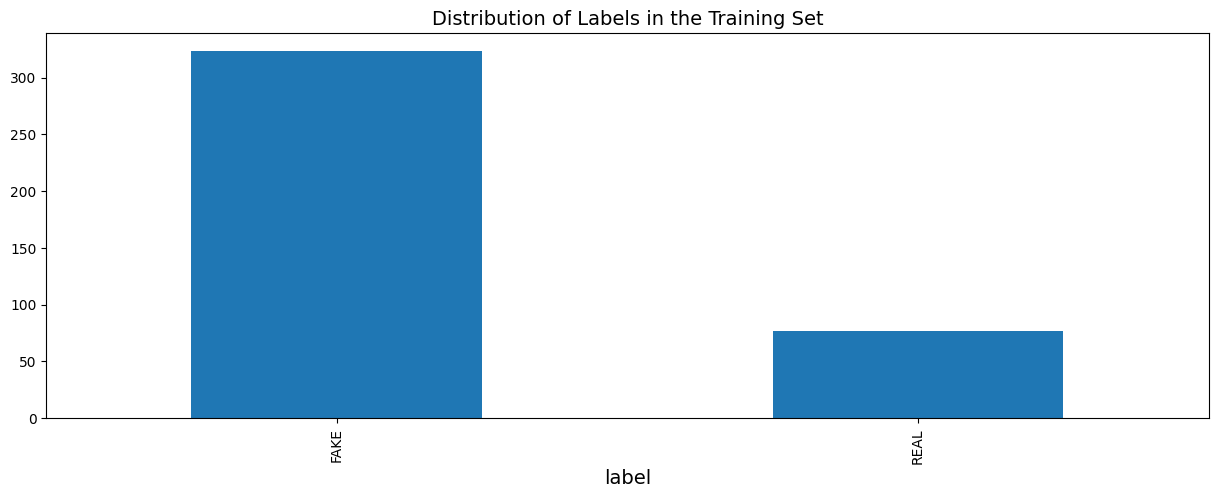

(400, 3)

In [43]:
DATA_FOLDER = '../input/deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

train_sample_metadata = pd.read_json('../input/deepfake-detection-challenge/train_sample_videos/metadata.json').T
train_sample_metadata.head()

train_sample_metadata.groupby('label')['label'].count().plot(figsize=(15, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

train_sample_metadata.shape